### Track Geo satellites!

This is how to show geo satellies

In [1]:
import sys
import pickle
import numpy as nmp
import graph as grf
import coord_trans
import space_track_api as api

from tqdm import tqdm
from satellite import Satellite
from satellite import GraphFrame
from datetime import datetime, timedelta

Load local tle file

Set input arguments:

epoch start

epoch end (relative time after)

start longitude

target name


Epoch 0 is pulled from the TLE; gives the most accurate orbit

Epoch 1 is the start time of the simulation

Epoch 2 is the end time of the simulation

In [2]:
days = 0
hours = 3
epoch1 = datetime.utcnow()
epoch2 = epoch1 + timedelta(days,0,0,0,0,hours)
#datetime.timedelta([d,] [sec,] [microsec,] [msec,] [min,] [hr,] [week])

lon0 = 160
target_name = 'INTELSAT 19'

load TLE file locally (normally done live via spacetrack.org)

In [3]:
with open('geo.tle', 'rb') as f:
    tle_list = pickle.load(f)

Calculate TLE orbits

lon0 is the global starting point; defined by user

lon1 is the tracked satellite's longitude

lon2 is the global ending point; target's longitude

In [4]:
sat_list = [Satellite(epoch1, epoch2) for n in range(0, len(tle_list), 3)]

for n, sat in enumerate(tqdm(sat_list, desc='Loading Satellites')):
    tle = tle_list[n*3:n*3+3]
    sat.load_tle(tle)

    if target_name in sat.name:
        sat.type = 'target'
        sat_target = sat

Loading Satellites: 100%|██████████| 1353/1353 [00:04<00:00, 337.19it/s]


Parse out only objects in specified region

In [5]:
tmp_list = []
for n, sat in enumerate(sat_list):
    lon1 = sat.lon[0]
    lon2 = sat_target.lon[0]

    if (lon1 >= lon0 and lon1 <= lon2 and lon2 > lon0) \
    or (lon1 <= lon0 and lon1 >= lon2 and lon2 < lon0):
        tmp_list.append(sat)

sat_list = tmp_list

Calculate motion for all epochs

In [6]:
for n, sat in enumerate(tqdm(sat_list, desc='Computing Motion')):
    sat.get_motion()

Computing Motion: 100%|██████████| 17/17 [00:02<00:00,  5.31it/s]


ADD RSV (change name)

In [7]:
sat_list.append(Satellite(epoch1, epoch2, [lon0, sat_target.lon[0]]))

Reformat data for 3D animation

In [8]:
frame_cnt = sat_list[0].sim_cnt
frame_list = [GraphFrame(sat_list) for n in range(frame_cnt)]

for n, frame in enumerate(tqdm(frame_list, desc='Building Frames')):
    frame.load_data(n)

Building Frames: 100%|██████████| 108/108 [00:00<00:00, 7259.02it/s]


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

In [10]:
def update_graph(f, frame_list, ax, cnt):

    ax.clear()
    f = nmp.mod(f, cnt)
    frame = frame_list[f]
    dt = frame.dt/3600

    for n in range(len(frame.marker)):
        x, y, z, s, c, m, name = frame.get_params(n)

        #WORKING
        ax.scatter(x, y, z, s=s, c=c, marker=m)
        ax.text(x+0.1, y+0.1, z+0.1, '%s'%(name), size=5, zorder=1)
        ax.text(0,155,36250,'Mission Time: %.2f hr'%(f*dt), size=20)
        #ax.text(0,155,36000,'%s / %s'%(f, cnt-1), size=20)

        ax.set_xlabel('Latitude, deg')
        ax.set_ylabel('Longitude, $\circ$E')
        ax.set_zlabel('Altitude, km')

        ax.set_xlim3d(-3,13)
        ax.set_ylim3d(150, 167)
        ax.set_zlim3d(35600,36100)

print results and graph

epoch start:  2019-02-04 18:20:55.237597 
epoch end:  2019-02-04 21:20:55.237597 



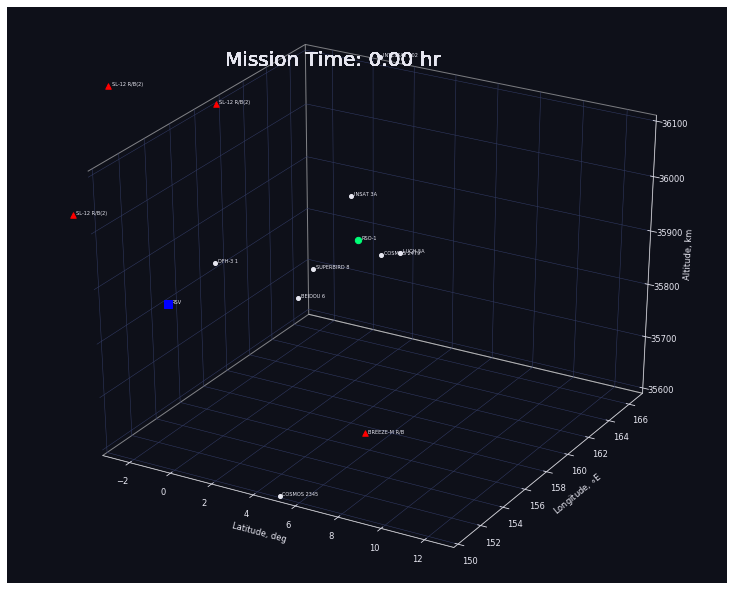

In [11]:
print('epoch start: ', epoch1, '\r')
print('epoch end: ', epoch2, '\n')

fig = plt.figure()
fig.set_size_inches(10, 8, True)
ax = fig.add_subplot(111, projection='3d')

frame_cnt = len(frame_list)

#ani = animation.FuncAnimation(fig, update_graph, frame_cnt,
        #fargs=(frame_list, ax, frame_cnt), interval=600)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.tight_layout(pad=0)
#plt.show()

ani = animation.FuncAnimation(fig, update_graph, frame_cnt,
        fargs=(frame_list, ax, frame_cnt), interval=600)

#plt.rcParams['animation.html']='html5'
#ani

from IPython.display import HTML
HTML(ani.to_html5_video())

#plt.rc('animation', html='html5')
#ani